In [13]:
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import folium
from folium import plugins
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt

In [ ]:
# Load the HTML file content
file_path = '/Users/guang/Desktop/Project/Data/Chrome Data/Google – My Activity Complete.html'  # pathname

# Function to read file with a specified encoding, ignoring errors
def read_file(file_path, encoding):
    with open(file_path, 'r', encoding=encoding, errors='ignore') as file:
        return file.read()

# Use the 'ISO-8859-1' encoding
html_content = read_file(file_path, 'ISO-8859-1')

soup = BeautifulSoup(html_content, 'html.parser')

all_elements = soup.find('div', {'class': 'ez10qf'}).find_all('div')

date_attr_dict = {'jsname': 'i6CNtf', 'jscontroller': 'IcmULc'}
loc_attr_dict = {'jsname': 'MFYZYe', 'class': "GqCJpe u2cbPc LDk2Pd".split()}
#cards_to_discard = ['Used Maps', 'Explored on Google Maps']
dates = []
data = {}
current_date = None

for element in all_elements:
    check_date = [element.has_attr(attr) and element[attr] == val for attr, val in date_attr_dict.items()]
    if all(check_date):
        current_date = element['data-date']
        data[current_date] = []
        dates.append(current_date)
    
    # Check if the element has the required div and a tag with href
    qtgv3c_div = element.find('div', {'class': 'QTGV3c'})
    has_required_link = qtgv3c_div and qtgv3c_div.find('a', href=True)
    
    check_loc = [element.has_attr(attr) and element[attr] == val for attr, val in loc_attr_dict.items()]
    #check_cards_to_discard = [x not in str(element) for x in cards_to_discard]
    if current_date is not None and all(check_loc) and has_required_link:
        google_link = element.find('div', {'class': 'QTGV3c'}).find('a')['href']
        time_val = element.find('div', {'class': "H3Q9vf XTnvW"}).text.split()[0]

        data[current_date].append({'time': time_val, 'link': google_link})

# Flattening the data structure
flattened_data = []
for date, entries in data.items():
    for entry in entries:
        flattened_data.append({
            'date': date,
            'time': entry['time'],
            'link': entry['link']
        })

df = pd.DataFrame(flattened_data)

# Convert the 'date' column to the correct date format
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Function to extract latitude and longitude from a link
def extract_lat_long(link):
    try:
        # Finding the part of the link after '@'
        lat_long_part = link.split('@')[1]
        # Extracting latitude and longitude values
        lat, long = lat_long_part.split(',', 2)[:2]
        return float(lat), float(long)
    except Exception:
        # In case of any error, return NaN values
        return float('nan'), float('nan')

# Apply the function to the 'link' column
df['latitude'], df['longitude'] = zip(*df['link'].apply(extract_lat_long))

df.to_csv('/Users/guang/Desktop/Project/extracted_data.csv', index=False)

In [14]:
df = pd.read_csv('/Users/guang/Desktop/Project/extracted_data.csv')
df.head()

date   time                                               link  \
0  2023-12-11  23:57  https://www.google.com/maps/@40.8939025,29.380...   
1  2023-12-11  23:55  https://www.google.ae/maps/dir//Orta+Mahalle,+...   
2  2023-12-11  18:51  https://www.google.com/maps/@40.9237874,29.311...   
3  2023-12-11  18:46  http://maps.google.com/maps?q=Fizyoterapist+Ze...   
4  2023-12-11  18:46  https://www.google.com/maps/@40.8566258,29.145...   

    latitude  longitude  
0  40.893903  29.380564  
1  40.891496  29.380405  
2  40.923787  29.311727  
3        NaN        NaN  
4  40.856626  29.145704

In [15]:
ISTANBUL_BOUNDING_BOX = {
    'min_lon': 28.0,  # Approximate minimum longitude
    'min_lat': 40.8,  # Approximate minimum latitude
    'max_lon': 29.5,  # Approximate maximum longitude
    'max_lat': 41.3   # Approximate maximum latitude
}

df = df[
    (df['longitude'] >= ISTANBUL_BOUNDING_BOX['min_lon']) &
    (df['longitude'] <= ISTANBUL_BOUNDING_BOX['max_lon']) &
    (df['latitude'] >= ISTANBUL_BOUNDING_BOX['min_lat']) &
    (df['latitude'] <= ISTANBUL_BOUNDING_BOX['max_lat'])
]

In [16]:
def dist_to_sabanci(x):

    lat = x['latitude']
    long = x['longitude']

    if pd.isnull(lat) or pd.isnull(long):
        return np.nan

    sabanci_coord = (40.8910, 29.3783)

    return geopy.distance.geodesic(sabanci_coord, (lat, long)).km

df['distance'] = df.apply(dist_to_sabanci, axis=1)

Text(0.5, 1.0, 'Distance Travelled from Sabanci University')

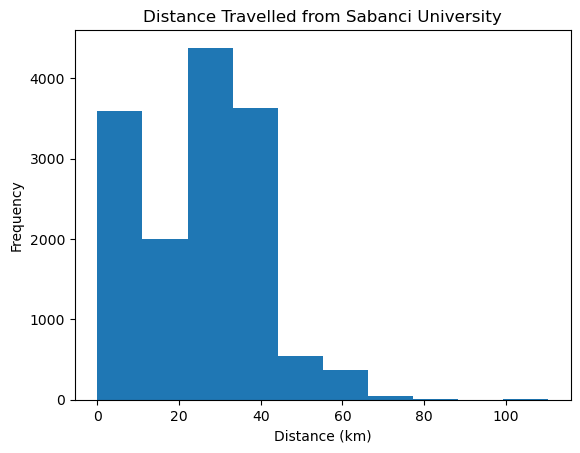

In [17]:
df['distance'].plot(kind='hist')
plt.xlabel("Distance (km)")
plt.title("Distance Travelled from Sabanci University")

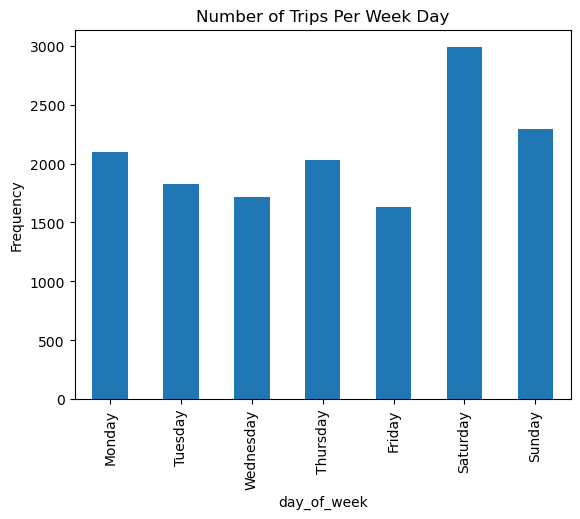

In [18]:
df['datetime'] = df['date'] + 'T' + df['time']
df['datetime'] = pd.to_datetime(df['datetime'])

df['day_of_week'] = df['datetime'].dt.day_of_week
weekdays_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

ax = df.groupby('day_of_week')['date'].count().plot(kind='bar')
ax.set_xticks(list(weekdays_dict.keys()))
ax.set_xticklabels(list(weekdays_dict.values()))
plt.ylabel("Frequency")
plt.title("Number of Trips Per Week Day")
plt.show()

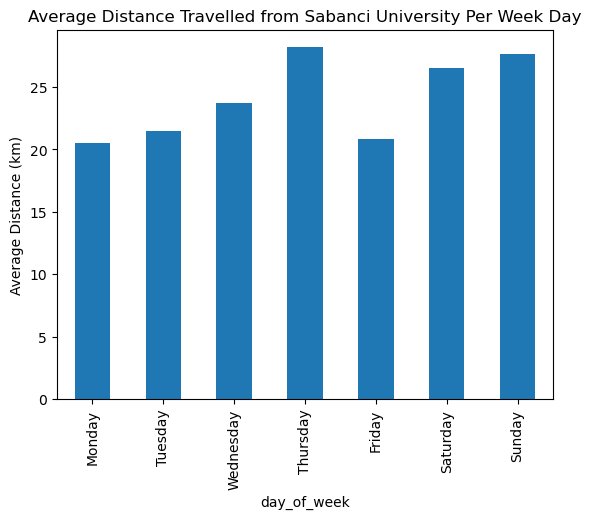

In [19]:
ax = df.groupby('day_of_week')['distance'].mean().plot(kind='bar')
ax.set_xticks(list(weekdays_dict.keys()))
ax.set_xticklabels(list(weekdays_dict.values()))
plt.ylabel("Average Distance (km)")
plt.title("Average Distance Travelled from Sabanci University Per Week Day")
plt.show()

Text(0.5, 1.0, 'Number of Trips Per Month')

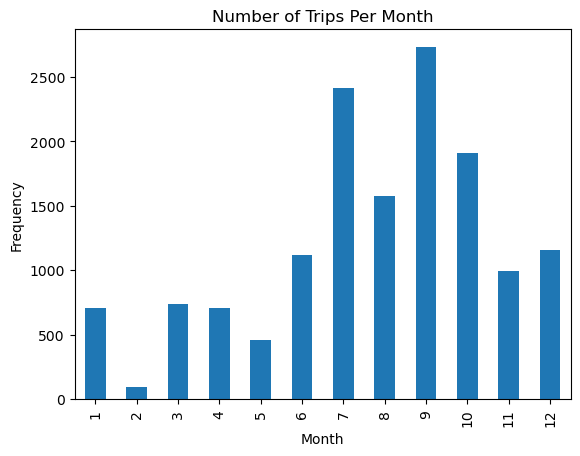

In [20]:
df.groupby(df['datetime'].dt.month)['date'].count().plot(kind='bar')
plt.ylabel("Frequency")
plt.xlabel("Month")
plt.title("Number of Trips Per Month")

Text(0.5, 1.0, 'Number of Trips Travelled Per Day')

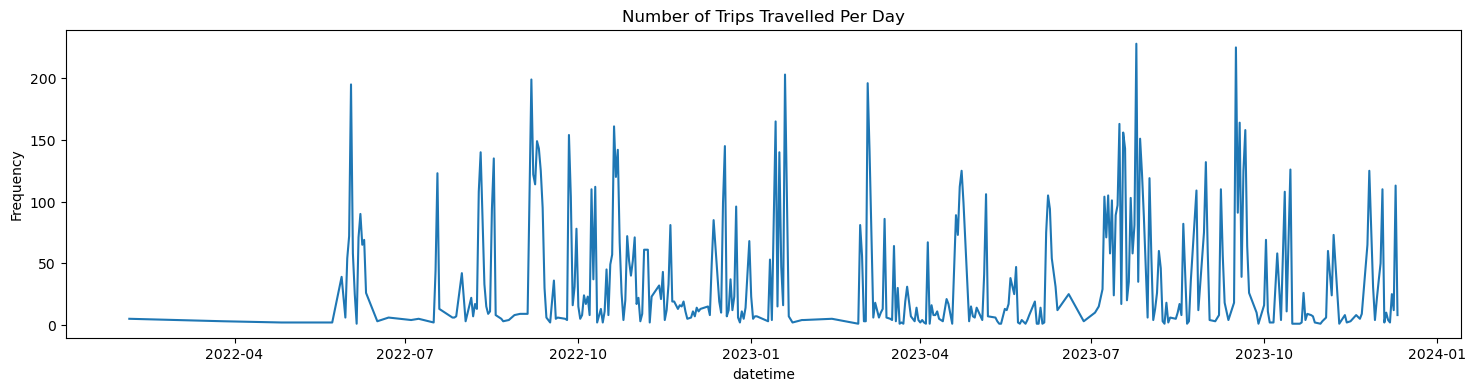

In [21]:
fig, ax = plt.subplots(figsize=(18, 4))
df.groupby(df.datetime.dt.date).count()['date'].plot(ax=ax)
plt.ylabel("Frequency")
plt.title("Number of Trips Travelled Per Day")

Text(0.5, 1.0, 'Average Distance Travelled Per Day')

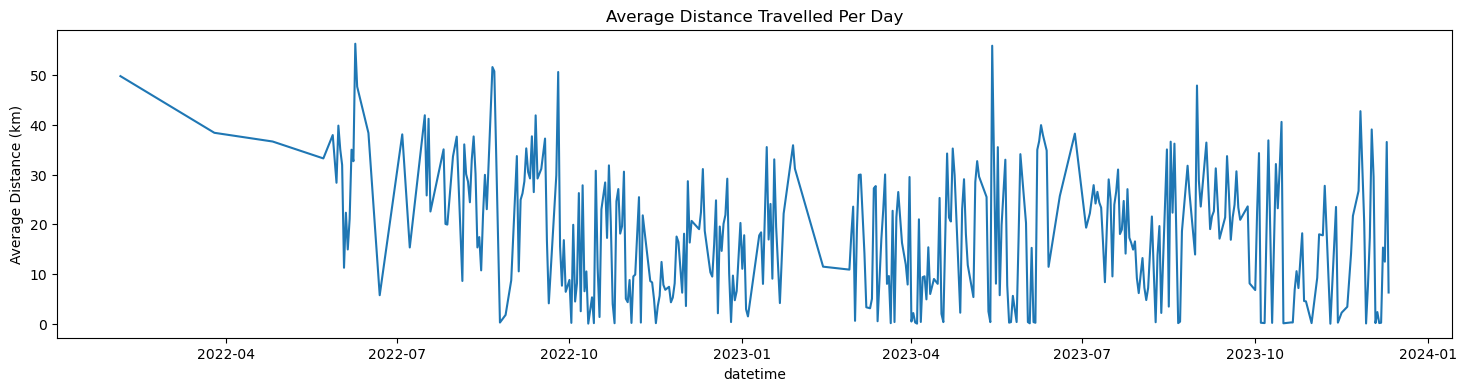

In [22]:
fig, ax = plt.subplots(figsize=(18, 4))
df.groupby(df.datetime.dt.date)['distance'].mean().plot(ax=ax)
plt.ylabel("Average Distance (km)")
plt.title("Average Distance Travelled Per Day")

In [23]:
df = df.dropna(subset=['latitude', 'longitude'])

# Create a map centered around Istanbul
istanbul_map = folium.Map(location=[41.035665, 29.048957], zoom_start=12)

# Create a list of coordinates
heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]

# Create a Heat Map
plugins.HeatMap(heat_data, radius=15, blur=10, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 1: 'red'}).add_to(istanbul_map)

# Cluster
marker_cluster = folium.plugins.MarkerCluster().add_to(istanbul_map)
for index, row in df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(marker_cluster)
istanbul_map.save('/Users/guang/Desktop/Project/istanbul_map.html')
istanbul_map

In [8]:
df.to_csv("/Users/guang/Desktop/Project/cleaned_data.csv", index=False)